In [361]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2
from datetime import datetime as dt

from models.CNN import CNNForecaster

from utils import reverse_forecast
from matplotlib.patches import Rectangle

In [362]:
x_test = torch.tensor(np.load('data/test_video/x_test.npy'), dtype=torch.float32).detach()
y_test = torch.tensor(np.load('data/test_video/y_test.npy'), dtype=torch.float32).detach()
actual = y_test.clone()

model = CNNForecaster((4, 10), (4, 1), 2, 0.0, 32)
model.load_state_dict(torch.load('saved_models/human_motion_model.pt', map_location=torch.device('cpu')))
model.eval()

CNNForecaster(
  (embedding): Linear(in_features=40, out_features=320, bias=False)
  (conv_layers): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (conv_seq): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (fc): Linear(in_features=320, out_features=4, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [363]:
def mse(arr1, arr2):
    return torch.sqrt(torch.sum((arr1 - arr2)**2, dim=1))

img_path = "/Users/abhiram/Documents/NFS/basketball_player/240/basketball_player"

import cvlib as cv

def yolo():
    hist_truth = torch.cat((x_test, y_test), dim=-1)
    
    yolo_truth = torch.zeros_like(hist_truth)
    
    
    curr_img = cv2.imread(f'{img_path}/00001.jpg')
    bbox, label, conf = cv.detect_common_objects(curr_img, confidence=0.1, model='yolov4-tiny')
    height, width, _ = curr_img.shape
    print(f'height: {height}, width: {width}')
    writer = cv2.VideoWriter('out/test_video_yolo.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 60, (width, height))

    for i in tqdm(range(1, (y_test.shape[-1] // 10 * 10) + 1)):
        curr_img = cv2.imread(f'{img_path}/{i:05d}.jpg')
        if (i <= 10) or (i % 10 == 0):
            bbox, label, conf = cv.detect_common_objects(curr_img, confidence=0.0, model='yolov4')
            curr_img = cv.object_detection.draw_bbox(curr_img, bbox, label, conf)
            bbox_t, label, conf = torch.tensor(bbox), np.array(label), torch.tensor(conf)
            bbox_t[:, 2] -= bbox_t[:, 0]
            bbox_t[:, 3] -= bbox_t[:, 1]
            bbox_t = bbox_t.T[np.newaxis, :, :]
            
            mse_idx = mse(bbox_t, hist_truth[:, :, i-1:i]).argmin(dim=-1)
            
            writer.write(curr_img)
            bbox, label, conf = bbox[mse_idx:mse_idx+1], label[mse_idx:mse_idx+1], conf[mse_idx:mse_idx+1]
            
            
            curr_img = cv.object_detection.draw_bbox(curr_img, bbox, ['sports ball'], conf)
            
            bbox[0][2] -= bbox[0][0]
            bbox[0][3] -= bbox[0][1]
            
            yolo_truth[:, :, i-1] = torch.tensor(bbox[0])
        writer.write(curr_img)
                
    
    writer.release()
    return yolo_truth

yolo_truth = yolo()

height: 720, width: 1280


In [364]:
x_test = yolo_truth[:, :, :10]

y_test = yolo_truth[:, :, 10:]

# for i in range(0, y_test.shape[-1], 10):
#     print('-------------------')
#     print(actual[0, :, i])
#     print(y_test[0, :, i])

In [365]:
def run_model(model, history, truth):
    history = history.clone().detach() 
    truth = truth.clone().detach() 
    truth = truth[:, :, :(truth.shape[-1] // 10 * 10)]
    model.eval()
    with torch.no_grad():
        predictions = torch.zeros_like(truth)
        for iteration in range(truth.shape[2] // 10):
            pred_series = torch.zeros((1, 4, 10))
            for i in range(10):
                input_hist = torch.cat((history[:, :, -(10-i):], pred_series[:, :, :i]), dim=-1)
                pred = torch.round(model(input_hist))
                pred_series[:, :, i] = pred
            
            predictions[:, :, (iteration*10):((iteration+1)*10)] = pred_series

            fts = 10 * (iteration + 1)
            future = truth[:, :, fts-1].unsqueeze(-1)
            
            interpolated = reverse_forecast(history[:, :, -10:],
                                            list(range(10)),
                                            future,
                                            19, deg=1)
            interpolated = torch.round(interpolated)
            history = torch.cat((history, interpolated), dim=-1)
        
        return predictions

def midpoint(arr):
    arr = arr[0, :, :]
    x = arr[0] + .5 * arr[2]
    y = arr[1] + .5 * arr[3]
    return np.array([x, y])

def ade(pred, truth):
    pred = pred[0, :, :]
    truth = truth[0, :, :]
    return torch.mean(torch.sqrt(torch.sum((pred - truth)**2, dim=1)))



Time Taken: 0:00:01.250713


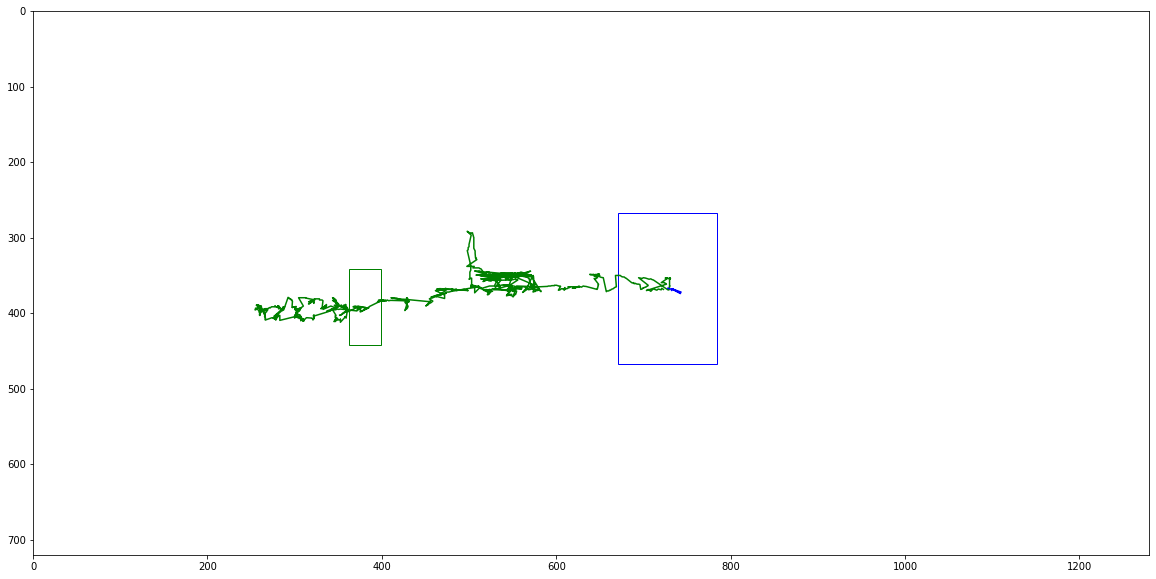

ADE: tensor(583.4278)


In [366]:
start = dt.now()
predictions = run_model(model, x_test, y_test)
end = dt.now()
print("Time Taken:", end - start)


hist_mid = midpoint(x_test.detach().numpy())
predictions_mid = midpoint(predictions.detach().numpy())
truth_mid = midpoint(y_test.detach().numpy())


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(predictions_mid[0], predictions_mid[1], 'g-', label='Predictions')
ax.plot(hist_mid[0], hist_mid[1], 'b-', label='History')
ax.plot(truth_mid[0, ::10], truth_mid[1, ::10], 'r-', label='Truth')

ax.add_patch(Rectangle((x_test[0, 0, -1], x_test[0, 1, -1]), x_test[0, 2, -1], x_test[0, 3, -1], fill=False, edgecolor='blue'))
ax.add_patch(Rectangle((y_test[0, 0, -1], y_test[0, 1, -1]), y_test[0, 2, -1], y_test[0, 3, -1], fill=False, edgecolor='red'))
ax.add_patch(Rectangle((predictions[0, 0, -1], predictions[0, 1, -1]), predictions[0, 2, -1], predictions[0, 3, -1], fill=False, edgecolor='green'))

ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)
ax.invert_yaxis()

plt.show()

print("ADE:", ade(predictions, actual[:, :, :-(actual.shape[-1] % 10)]))

In [367]:
"""
Create a video file of the detected objects
"""

import cvlib as cv

curr_img = cv2.imread(f'{img_path}/00001.jpg')
# bbox, label, conf = cv.detect_common_objects(curr_img, confidence=0.1, model='yolov4-tiny')
height, width, _ = curr_img.shape
print(f'height: {height}, width: {width}')
writer = cv2.VideoWriter('out/test_video_out.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 240, (width, height))

for i in tqdm(range(1, (y_test.shape[-1] // 10 * 10) + 1)):
    curr_img = cv2.imread(f'{img_path}/{i:05d}.jpg')
    if i < 10:
        bbox = [x_test[0, :, i-1].detach().numpy().flatten()]
        label = ['actual']
        conf = [1]
        color = [(0, 255, 0)]
    if i > 10:
        bbox = [y_test[0, :, i-11].detach().numpy().flatten(),
                predictions[0, :, i-11].detach().numpy().flatten()]
        label = ['truth', 'pred']
        conf = [1, 1]
        color = [(0, 0, 255), (0, 0, 255)]
        
    for bb, l, c, col in zip(bbox, label, conf, color):
        x, y, w, h = bb
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        cv2.rectangle(curr_img, (x, y), (x+w, y+h), col, 2)
    
    writer.write(curr_img)

writer.release()

height: 720, width: 1280
